In [1]:
%load_ext autoreload
%autoreload 2

# first we need a bit of import boilerplate
import os
import sys
from sys import platform
if platform == 'win32':
    sys.path.append('D:/Brain_Network/Code/')
    manifest_path = 'D:/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = 'D:/Brain_Network/'
elif platform =='darwin':
    sys.path.append('/Users/chenyu/Workspace/Brain_Network/Code/')
    manifest_path = '/Users/chenyu/Workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/Users/chenyu/Workspace/Brain_Network/'
elif platform == 'linux':
    sys.path.append('/home/yuchen/workspace/Brain_Network/Code/')
    manifest_path = '/home/yuchen/workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/home/yuchen/workspace/Brain_Network/'
else:
    print('Add new computer system settings.')

import numpy as np; np.set_printoptions(linewidth=110);
import glob
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn
import scipy
import scipy.io as sio
from scipy.ndimage.filters import gaussian_filter
import seaborn
from tqdm.notebook import trange
import time

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_session import EcephysSession

# tell pandas to show all columns when we display a DataFrame
pd.set_option("display.max_columns", None)

import hierarchical_model_generator
import hierarchical_sampling_model

In [2]:
import pandas as pd
print('pd', pd.__version__)
import allensdk
print('allensdk', allensdk.__version__)
import h5py
print('h5py', h5py.__version__)
import pynwb
print('pynwb', pynwb.__version__)
import hdmf
print('hdmf', hdmf.__version__)

pd 1.1.1
allensdk 2.2.0
h5py 2.8.0
pynwb 1.4.0
hdmf 2.2.0


# Hierarchical model Generator

### Load tamplate model

In [5]:
model_files = [
'HBM_checkpoint_B_MC_0_500ms_probeCE_condition1_20200813-092937_generator_template.pkl',
'HBM_checkpoint_BSS_MC_0_500ms_probeCE_o225_270_f8_20200801-174224_generator_template.pkl',
'HBM_checkpoint_BSS_MC_0_500ms_probeCDE_o225_270_f8_20200731-125456_generator_template.pkl',
'798911424_checkpoints_batch5_20201111-121627_generator_template.pkl', # B A3
'798911424_checkpoints_batch14_20201023-042306_generator_template.pkl']  # BSS A3

In [6]:

def runner(random_seed):
# random_seed = 0

    print(f'---------------------- {random_seed} --------------------')
    ## Load simulation
    generator_model = hierarchical_model_generator.HierarchicalModelGenerator()
    data_folder = project_dir + 'Output/simulation/'
    file_path = (data_folder + model_files[4])
    generator_model.load_model(file_path)

    np.random.seed(random_seed)  # Random seed for pseudo data.
    model_feature_type = 'BSS'
    generator_model.initial_step(model_feature_type=model_feature_type, num_trials=180, num_conditions = 1)

    ## Generate data
    select_clist = [4]
    generator_model.generate_mu_sigma(sample_type='fixed', verbose=False)
    generator_model.generate_q_old()
    generator_model.generate_f_pop_gac(select_clist=select_clist, same_as_cross=False, verbose=False)
    generator_model.generate_z(verbose=False)
    generator_model.generate_p_gac(verbose=False)
    generator_model.generate_log_lambda_nargc(verbose=False)
    generator_model.generate_spikes(verbose=False)

    ## Prepare for the data fitting.
    trial_time_window=generator_model.trial_time_window
    spike_train_time_line = generator_model.spike_train_time_line
    spike_trains, spike_times = generator_model.spike_trains, generator_model.spike_times
    session = None
    spike_counts, spike_shifts = generator_model.spike_counts, generator_model.spike_shifts
    units_probes = generator_model.selected_units['probe_description']
    probes = generator_model.probes
    selected_units = generator_model.selected_units
    trials_indices = generator_model.trials_indices
    trials_groups = generator_model.trials_groups

    ## Initial HBM
    np.random.seed(0)  # Random seed for MCMC chain.
    model = hierarchical_sampling_model.HierarchicalSamplingModel(session)
    model.initial_step(spike_trains, spike_times, spike_train_time_line, selected_units, trials_groups,
                       trial_time_window, probes=['probeC', 'probeD', 'probeE'], num_areas=3, num_groups=3, 
                       model_feature_type='BSS', prior_type='diag',
                       eta_smooth_tuning=3e-8, verbose=False)
    # Initialize with true values.
    model.set_model(generator_model, select_clist=select_clist)

    ##
    clist = [0]
    thin_begin = 0
    thin_step = 1

    t = trange(0, 2000)
    for itr in t:
        slc = (itr >= thin_begin) and (itr % thin_step == 0)
        for c in clist:
            if itr > 400:
                model.update_f_local_pop_cag(c, sample_type='sample', verbose=False)
                model.update_f_cross_pop_ca(c, sample_type='sample', record=(c==clist[-1] and slc), verbose=False)
            # proposal_scalar=0.1 BA2  0.04 BSS A3
            model.update_q_arc(c, sample_type='sample', proposal_scalar=0.02, fit_peak_ratio=0,
                               record=(c==clist[-1] and slc), verbose=False)
            if itr > 200 and itr % 20 == 0:
                model.update_z_ngac(c, sample_type='sample',
                                    record=(c==clist[-1]), verbose=False)
            if itr > 200:
                model.update_p_gac(c, sample_type='sample',
                                   record=(c==clist[-1] and slc), verbose=False)
        if itr > 200:
            model.update_mu_simga(clist=clist, sample_type='iw_sample', record=slc, verbose=False)
        model.complete_log_likelihood(clist)
        t.set_description(f'{model.samples.log_likelihood[-1]:.2f} | {model.samples.q_accept_ratio_mean:.3f}')

    ## KS test
    z_c = model.samples.get_z_mode(burn_in=0, end=None, step=1, sub_group_df_c=model.sub_group_df_c)
    lambda_garc = model.samples.get_lambda_garc(clist, spike_train_time_line, model_feature_type=model.model_feature_type,
            burn_in=600, end=None, step=1, samples_aligned='end', verbose=False)
    model.ks_test(clist, lambda_garc, z_c, test_size=0.05, null_type='sampling', num_null_samples=1000, correction=None)
    model.ks_test(clist, lambda_garc, z_c, test_size=0.001, null_type='sampling', num_null_samples=1000, correction=None)

    ## Output
    model.samples.plot_log_likelihood()
    error_rnd, error_hat, error_fix, CI_trap_rnd, CI_trap_hat, CI_trap_fix = model.samples.rho_mse_ci_coverage(
        burn_in=0, end=None, step=1, rho_type=['marginal', 'corrcoef'], true_model=generator_model, 
        model_feature_type=model.model_feature_type, verbose=True)
    # print(CI_trap_hat)
    print(CI_trap_rnd)
    print(CI_trap_fix)
    # model.samples.plot_marginal_correlation(0, 1, burn_in=0, end=None, step=1, plot_type='rho',
    #         true_model=generator_model, model_feature_type=model.model_feature_type,
    #         distribution_type='hist')

    ## Save data.
    experiment_name = (f'{model_feature_type}_0_500ms_probe3_R{len(trials_indices)}_' + 
                       f'sim_thinbegin{thin_begin}_thinstep{thin_step}_')
    timestr = time.strftime("%Y%m%d-%H%M%S")
    output_folder = project_dir + 'Output/simulation_output/BSS_A3_R180_diag_prior_fixed_sigma_df10_add_KS/'

    # Save estimated model.
    prefix = f'HBM_checkpoint_seed{random_seed}_'
    file_path = output_folder + prefix + experiment_name + timestr + '.pkl'
    model.save_model(save_data=False, file_path=file_path)
    # Save true model.
    prefix = f'HBM_generator_seed{random_seed}_'
    file_path = output_folder + prefix + experiment_name + timestr + '.pkl'
    generator_model.save_data(save_spikes=False, file_path=file_path)
    # Save samples.
    prefix = f'HBM_samples_seed{random_seed}_'
    file_path = output_folder + prefix + experiment_name + timestr + '.pkl'
    model.samples.save(file_path)

---------------------- 0 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
Model feature type:  BSS
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[38 33 23]  probeD g:[2 1 0] counts:[31 27 20]  probeE g:[2 1 0] counts:[36 31 22]  


[ 0.22287065  0.00156644 -0.07176247  0.06251656  0.05084961 -0.02617017  0.36723005 -0.00595404 -0.03830062]

z_samples.shape (1, 261, 89)
sources.shape: (1400, 3, 180, 1, 6)
targets.shape: (1400, 3, 180, 1, 6)
f_pop.shape: (1400, 1, 3, 3, 250)
q.shape: (1400, 3, 180, 1)
lambda_garc.shape: (3, 3, 180, 1, 250)
100%|█████████████████████████████████████████████████████████████████| 1/1 [01:36<00:00, 96.60s/it]
CI cnt 261  CI trap ratio 0.6628352490421456
zero neuron:2
100%|█████████████████████████████████████████████████████████████████| 1/1 [01:38<00:00, 98.97s/it]
CI cnt 261  CI trap ratio 0.9310344827586207
zero neuron:2


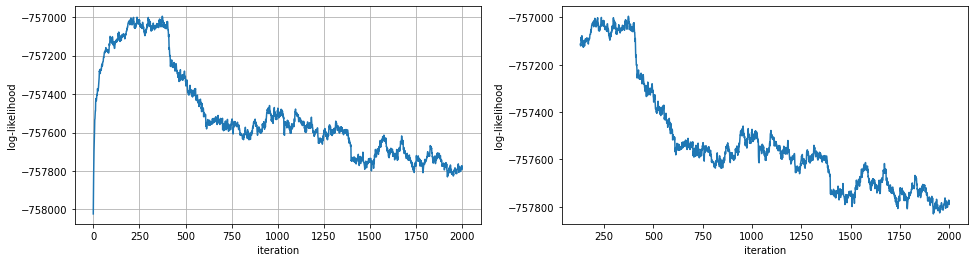

rho_samples.shape: (1800, 9, 9)
CI traps hat total, ratio: 36.0 1.0
CI traps rnd total, ratio: 32.0 0.8888888888888888
CI traps fix total, ratio: 33.0 0.9166666666666666
[[0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 0. 1. 0. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 1. 1. 1. 1. 1. 0. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


D:/Brain_Network/Code\util.py:514: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


---------------------- 1 --------------------
model_feature_type: BSS

num areas 3   num trials 180   num conditions 1   num qs 3
Model feature type:  BSS
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[38 33 23]  probeD g:[2 1 0] counts:[31 27 20]  probeE g:[2 1 0] counts:[36 31 22]  


[-0.2985193  -0.00930439 -0.07493181 -0.2959919  -0.00195706 -0.01553397 -0.16376045  0.00704679 -0.02161745]
[-0.03155739  0.01787419 -0.02946541  0.54002969  0.05931422 -0.04891323  0.55957316 -0.00847314 -0.07835153]

z_samples.shape (1, 261, 89)
sources.shape: (1400, 3, 180, 1, 6)
targets.shape: (1400, 3, 180, 1, 6)
f_pop.shape: (1400, 1, 3, 3, 250)
q.shape: (1400, 3, 180, 1)
lambda_garc.shape: (3, 3, 180, 1, 250)
100%|████████████████████████████████████████████████████████████████| 1/1 [01:40<00:00, 100.90s/it]
CI cnt 261  CI trap ratio 0.6628352490421456
zero neuron:2
100%|█████████████████████████████████████████████████████████████████| 1/1 [01:39<00:00, 99.53s/it]
CI cnt 261  CI trap ratio 0.9616858237547893
zero neuron:2


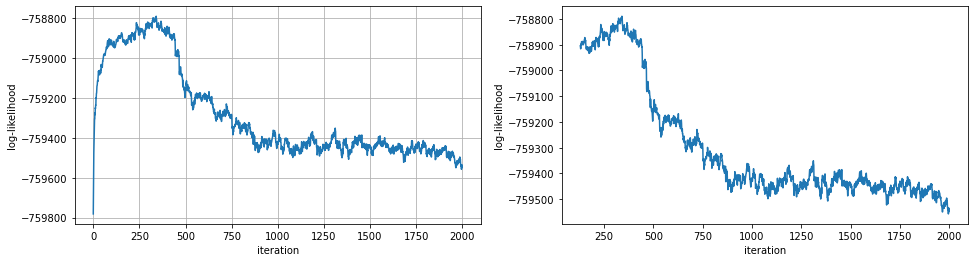

rho_samples.shape: (1800, 9, 9)
CI traps hat total, ratio: 36.0 1.0
CI traps rnd total, ratio: 36.0 1.0
CI traps fix total, ratio: 33.0 0.9166666666666666
[[0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 1. 1. 1. 1. 1. 0. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 0. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


D:/Brain_Network/Code\util.py:514: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


In [7]:
seed_range = trange(0, 2)
for random_seed in seed_range:
    runner(random_seed)